In [1]:
import warnings
warnings.filterwarnings("ignore")

SEED = 1
N_IMG = 1

In [2]:
import random

import diffusers
import numpy as np
import torch

from src.diffusion_models import SDXLEditingPipeline

device = torch.device("cuda:1")
device1 = torch.device("cuda:2")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
base = SDXLEditingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device1)
use_ddpm = True
if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Using DDPM as scheduler.


In [4]:
prompts = [
    "Two people enjoying hot dogs and soda pop.",
    "Two people walking under an umbrella on a street near some benches and a motorcycle.",
    "a woman in a blue top carrying two surfboards across a street",
    "A woman surfer riding on a crashing wave",
    "A man walking along a beach holding a surfboard"
]

In [5]:
generator = torch.Generator(device=device1).manual_seed(SEED)
out = base(prompt=[prompts[0]]*N_IMG, num_inference_steps=300, generator=generator, latents=None)

100%|██████████| 300/300 [00:37<00:00,  7.97it/s]


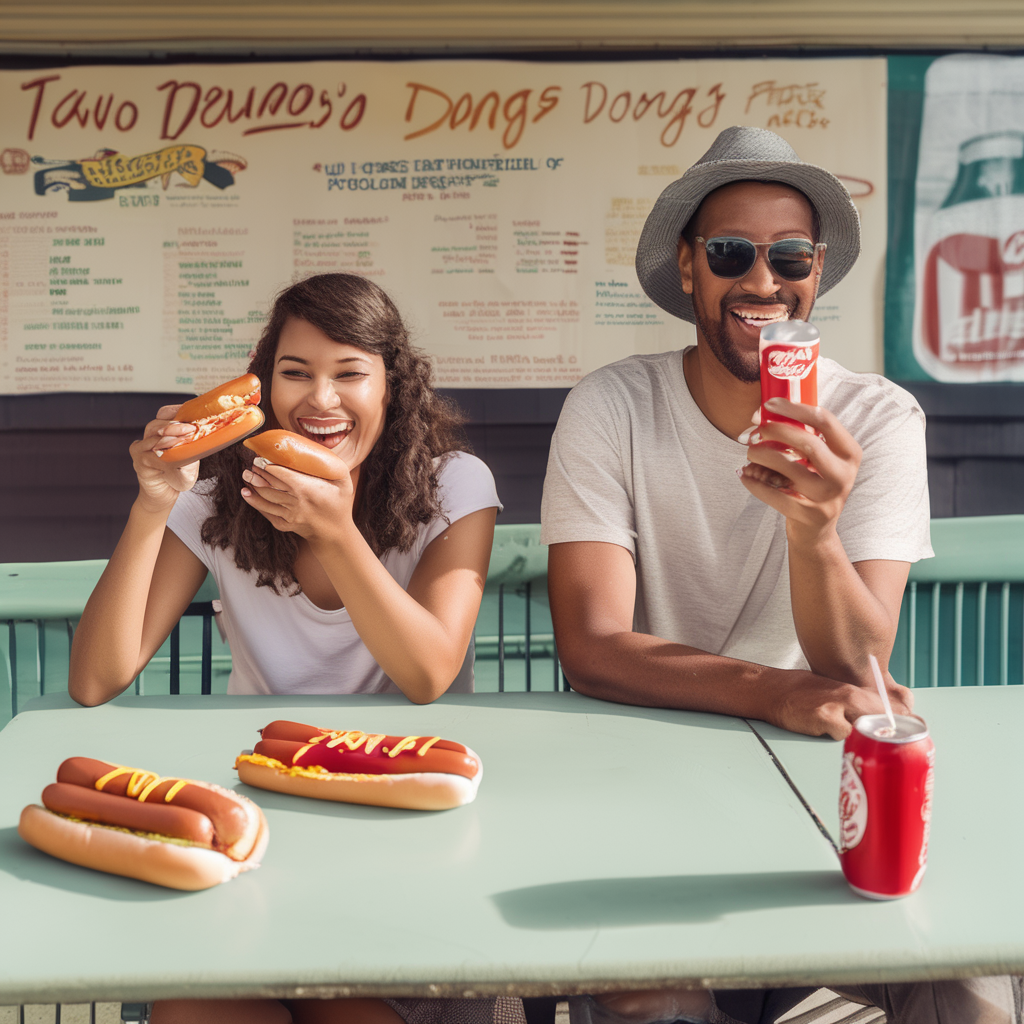

In [6]:
out.images[0]

In [7]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type (e.g., "people", "monkey"), the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes (e.g., "green", "happy") for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.
"""

In [8]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
model.eval()
model.to("cuda:0")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  9.21it/s]


LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): Q

In [9]:
responses = []
images = []
for i, prompt in enumerate(prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"
    out = base(prompt=[prompt]*N_IMG, num_inference_steps=300, generator=generator, latents=None)
    out.images[0].save(f"../samples/img{i}.png","PNG")
    images.append(out.images[0])

    inputs = processor(query, out.images[0], return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:37<00:00,  7.94it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
100%|██████████| 300/300 [00:37<00:00,  7.90it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:38<00:00,  7.87it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:38<00:00,  7.87it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 300/300 [00:38<00:00,  7.87it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [10]:
for response in responses:
    print(response)
    print("--------")

INST] Based on the image provided, here is the list of tuples as per your request:

[('people', ['two']), ('hot dog', ['one']), ('soda pop', ['two'])]

Please note that the image does not provide specific details about the color of the hot dogs or the soda pop, so I have assumed they are the typical colors associated with these items. If you need more detailed information, please provide additional details or clarify the prompt. </s>
--------
INST] Based on the image provided, here is the list of tuples as per the user prompt:

[('people', ['walking', 'under umbrella']), ('motorcycle', ['parked'])] </s>
--------
INST] Based on the image provided, here is the list of tuples as per the user prompt:

[('people', ['a woman']), ('surfboards', ['two surfboards'])] </s>
--------
INST] Based on the image provided, here is the list of tuples as per the task:

[('people', ['surfer']), ('monkey', [None])] </s>
--------
INST] Based on the image provided, here is the list of tuples as per the user 

### As you can see, although the model returned the list of objects in the required format, the object types and attributes sometimes are created by the model and are not mentioned in the prompt. Moreover, not all objects mentioned in the prompt and presented in the image are actually extracted. For instance, in the first prompt, the hot dogs and soda pop are not extracted.

## Try to add examples of response

In [11]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type (e.g., "people", "monkey"), the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes (e.g., "green", "happy") for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of response:

- Example 1
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]
"""

In [12]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"[INST] {instruction}\n\nImage: <image>\nUser Prompt: {prompt}[/INST]"

    inputs = processor(query, image, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0])[len(query):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
prompts = [
    "Two people enjoying hot dogs and soda pop.",
    "Two people walking under an umbrella on a street near some benches and a motorcycle.",
    "a woman in a blue top carrying two surfboards across a street",
    "A woman surfer riding on a crashing wave",
    "A man walking along a beach holding a surfboard"
]

In [13]:
for response in responses:
    print(response)
    print("--------")

INST] Objects: [('people', ['two']), ('hot dog', ['one']), ('soda pop', ['two'])] </s>
--------
INST] Objects: [('people', ['two']), ('umbrella', ['black']), ('motorcycle', ['black']), ('bench', ['two'])] </s>
--------
INST] Objects: [('surfboard', ['blue', 'orange']), ('woman', ['blue top'])] </s>
--------
INST] Objects: [('surfer', ['woman'])] </s>
--------
INST] Objects: [('man', ['walking']), ('surfboard', ['white'])] </s>
--------


### The results became significantly better, but it sometimes still mentions quantities instead of attributes and returns the attributes not mentioned in the prompt